# Subsampling approaches to MCMC for tall data

Last modified on 11th May 2015

This notebook illustrates various approaches to subsampling MCMC, see (Bardenet, Doucet, and Holmes, ICML'14 and a 2015 arxiv preprint entitled "On MCMC for tall data" by the same authors. By default, executing cells from top to bottom will reproduce the running examples in the latter paper. If you want to jump to a particular method, you should at least evaluate the first two sections beforehand ("Generate..." and "Vanilla MH"), as they contain functions and data that is used throughout the notebook. Please report any issue (or interesting discovery!) to the paper's corresponding author.

**Table of contents**    
[Generate toy data](#Generate-toy-data)  
[Vanilla MH](#Vanilla-isotropic-Gaussian-random-walk-Metropolis)  
[Austerity MH](#Austerity-MH)  
[Confidence sampler without proxy](#Vanilla-confidence-sampler)  
[Poisson estimator](#Pseudo-marginal-MH-with-Poisson-estimator)  
[Confidence sampler with proxy](#Confidence-MH-with-2nd-order-Taylor-likelihood-proxy)  
[Firefly MH](#Firefly-MH-with-2nd-order-Taylor-lower-bound)  
[SGLD](#Stochastic-gradient-Langevin-dynamics)  


In [1]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import numpy.random as npr
import scipy.stats as sps
import scipy.special as spsp
import scipy.misc as spm
import scipy.optimize as spo
import numpy.linalg as npl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import random
import sympy as sym
import time
import seaborn as sns
import seaborn.distributions as snsd
import math as math
sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
npr.seed(1)

We will save Figures in the following directory, by default it is the current directory.

In [3]:
saveDirStr = ""

## Generate toy data

First, let us generate some data. Change variable "dataType" to switch between the Gaussian and the lognormal examples from the paper. 

In [156]:
# Generate data
npr.seed(1)
N = 100000
dataType = "Gaussian"
if dataType == "Gaussian":
    x = npr.randn(N)
elif dataType == "logNormal":
    x = npr.lognormal(0,1,size=N)

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)
print("Mean of x =", realMean)
print("Std of x =", realStd)

Mean of x = 0.005253028489682668
Std of x = 0.9983292735417362


We are going to estimate the mean and std deviation of a Gaussian model, applied to the toy dataset generated above.

In [5]:
def getLogLhd(x, mu, sigma):
    """
    return an array of Gaussian log likelihoods up to a constant
    """
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)

The following function plots the results as in the paper. It is a bit messy, but you can safely skip this cell without missing anything on the algorithms.

In [12]:
def plotResults(S, ns, algoName="doesNotMatter", weights="doesNotMatter", boolSave=0, figId="basic"):
    """
    plot results
    """    
    # Plot joint sample with seaborn
    m = np.min(S[:,0]) # Precompute limits for x and y plots
    M = np.max(S[:,0])
    m_ref = np.min(S_ref[:,0]) # Precompute limits for x and y plots
    M_ref = np.max(S_ref[:,0])
    
    xlimInf = min(m, m_ref)# - (M-m)/10
    xlimSup = max(M, M_ref)# +(M-m)/10
    print("xlims =", xlimInf, xlimSup) # +(M-m)/10
    xPlot = np.linspace(xlimInf, xlimSup, 1000)
    m = np.min(np.exp(S[:,1]))
    M = np.max(np.exp(S[:,1]))
    m_ref = np.min(np.exp(S_ref[:,1])) # Precompute limits for x and y plots
    M_ref = np.max(np.exp(S_ref[:,1]))
    ylimInf = min(m, m_ref)# - (M-m)/10
    ylimSup = max(M, M_ref)
    yPlot = np.linspace(ylimInf, ylimSup, 1000)
    
    if algoName == "sgld":
        # Need to convert a weighted sample into a unweighted sample
        sumWeights = np.sum(weights)
        normalizedWeights = weights/sumWeights
        T = S.shape[0]
        inds = npr.choice(np.arange(T), T, p=normalizedWeights)
        S = S[inds,:]
    
    g = sns.jointplot(S[:,0], np.exp(S[:,1]), kind="hex", space=0,size=10, xlim=(xlimInf,xlimSup), ylim=(ylimInf,ylimSup), stat_func=None, marginal_kws={"norm_hist":True}) # 
    plt.sca(g.ax_joint)
    plt.xlabel("$\mu$",)
    plt.ylabel("$\sigma$")
    
    # Add Reference long MH draw 
    # ... to the joint plot
    sns.kdeplot(S_ref[:,0], np.exp(S_ref[:,1]), ax=g.ax_joint, bw="silverman", cmap="BuGn_r", linewidth=5)
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, marg0(xPlot), 'g', linewidth=6, label="Ref")
    g.ax_marg_y.plot(marg1(yPlot), yPlot, 'g', linewidth=6)
    
    # Add Bernstein von Mises approximations
    # ... to the joint plot
    X, Y = np.meshgrid(xPlot, yPlot)
    minusFisher = np.array([[1./realStd**2, 0],[0, 2./realStd**2]])
    SS = 1./N*npl.inv(minusFisher)
    Z = plt.mlab.bivariate_normal(X, Y, sigmax=np.sqrt(SS[0,0]), mux=realMean, muy=realStd, sigmay=np.sqrt(SS[1,1]), sigmaxy=np.sqrt(SS[0,1])) # Plot BvM approximation
    g.ax_joint.contour(X, Y, -Z, 1, colors="r", label="BvM", linestyle='--',linewidths=(6))
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, sps.norm(realMean, np.sqrt(SS[0,0])).pdf(xPlot), color="red", linewidth=6, linestyle='--', label="BvM")
    g.ax_marg_y.plot(sps.norm(realStd, np.sqrt(SS[1,1])).pdf(yPlot), yPlot, color="red", linewidth=6, linestyle='--')
    
    # Print legend and save
    
    g.ax_marg_x.legend()
    print(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
    plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
      
    if boolSave:
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".eps")
    plt.show()    
        
    # Plot autocorr of second component
    c = plt.acorr(np.exp(S[:,1]), maxlags=50, detrend=detrend_mean, normed=True)
    plt.clf()
    c = c[1][c[0]>=0]
    plt.plot(c, linewidth=3)
    plt.plot(c_ref, label="Ref", linewidth=3, color="g")
    plt.grid(True)
    
    plt.legend(loc=1)
    if boolSave:
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".eps")
 
    plt.show()
      
    # Plot average number of likelihoods computed
    if not algoName =="vanillaMH":
        plt.hist(ns, histtype="stepfilled", alpha=.3)
        labStr = "mean="+str(np.around(1.0*np.mean(ns)/N*100,1))+"\%"
        plt.axvline(np.mean(ns), linewidth = 4, color="blue", label=labStr)
        labStr = "median="+str(np.around(1.0*np.median(ns)/N*100,1))+"\%"
        print("Median=", np.median(ns))
        plt.axvline(np.median(ns), linewidth = 4, color="blue",linestyle='--', label=labStr)
        plt.axvline(N, linewidth = 4, color="k", label="n") 
        plt.xlim([0, 2*N+1])
        plt.legend()
        if boolSave:
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".eps")
            print("Plots saved")
        plt.show()

## Vanilla isotropic Gaussian random walk Metropolis

In [162]:
def vanillaMH(T):
    """
    perform traditional isotropic random walk Metropolis
    """
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0
    
    for i in range(T):
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            print("Iteration", i, "Acceptance", acceptance)
            
    return S

In [158]:
def plot_trace(chain):
    '''
    Plots the trace of a given markov chain of Nx2 observations
    where 1st index of second dim is mean and 2nd index of second
    dim is std_dev.
    '''
    fig, (mean_ax, var_ax) = plt.subplots(2)
    steps = range(len(chain[:,0]))
    fig.suptitle('Trace of walk')
    mean_ax.set_title('Mean')
    mean_ax.plot(steps,chain[:,0])
    var_ax.set_title('log(Std)')
    var_ax.plot(steps,chain[:,1])
    plt.show()

In [243]:
# Longer reference run
S_ref = vanillaMH(50000)

Iteration 0 Acceptance 0.0
Iteration 5000 Acceptance 0.4973005398920214
Iteration 10000 Acceptance 0.512248775122487
Iteration 15000 Acceptance 0.5126991533897722
Iteration 20000 Acceptance 0.5121743912804347
Iteration 25000 Acceptance 0.5119795208191689
Iteration 30000 Acceptance 0.5145828472384287
Iteration 35000 Acceptance 0.5158995457272695
Iteration 40000 Acceptance 0.5163120921976968
Iteration 45000 Acceptance 0.5170329548232269


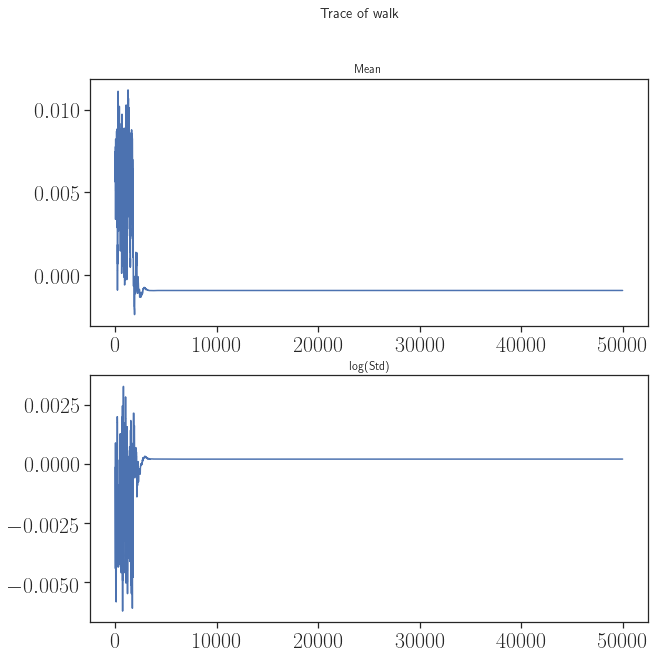

In [154]:
plot_trace(S_ref)

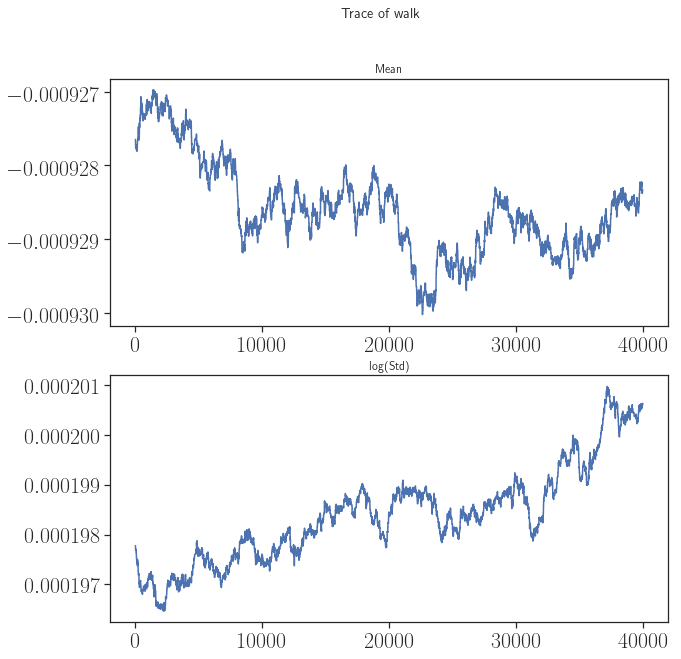

In [163]:
plot_trace(S_ref[10000:])

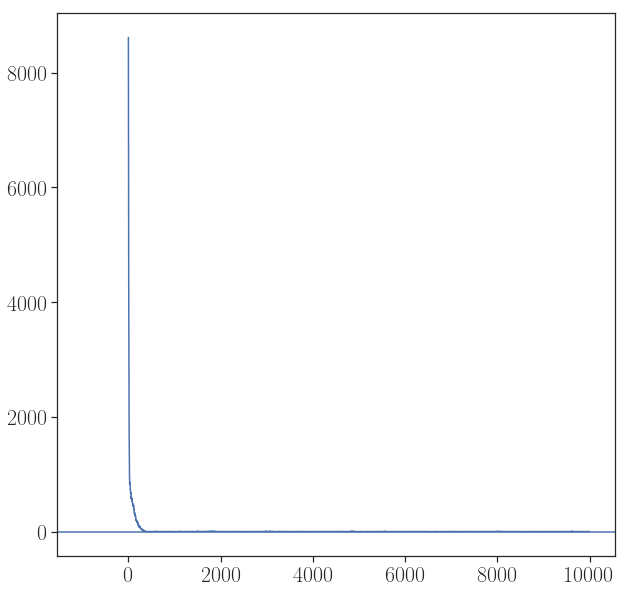

In [147]:
# Look for auto-correlation in mean and var chains
marg0 = sps.gaussian_kde(S_ref[:,0])
marg1 = sps.gaussian_kde(np.exp(S_ref[:,1]))
c = plt.acorr(np.exp(S_ref[:,1]), maxlags=200, detrend=detrend_mean, normed=True);
c_ref = c[1][c[0]>=0]
plt.show()

In [164]:
S = vanillaMH(10000)

Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.5014985014985016
Iteration 2000 Acceptance 0.4957521239380311
Iteration 3000 Acceptance 0.48783738753748757
Iteration 4000 Acceptance 0.4946263434141465
Iteration 5000 Acceptance 0.49250149970005996
Iteration 6000 Acceptance 0.49908348608565267
Iteration 7000 Acceptance 0.49935723468076054
Iteration 8000 Acceptance 0.4986876640419965
Iteration 9000 Acceptance 0.4963892900788817


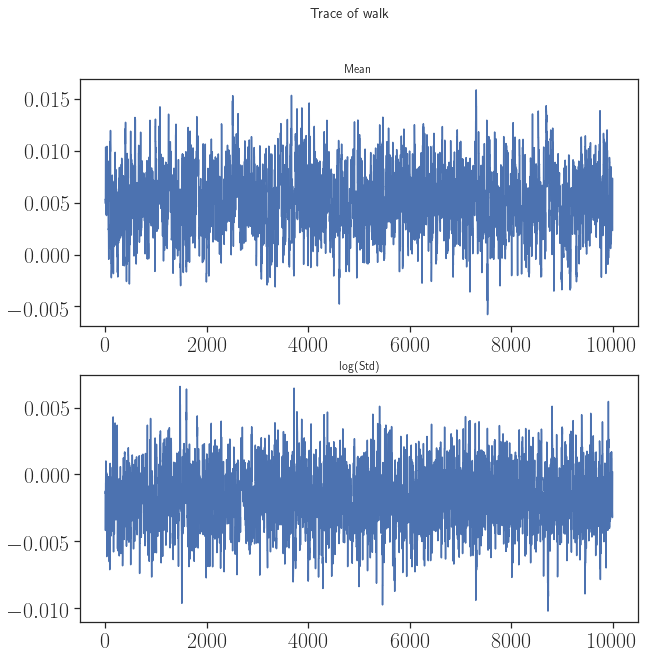

In [166]:
plot_trace(S)

xlims = -0.007791816639024665 0.01726257430530132
chain_Gaussian_vanillaMH_basic.pdf


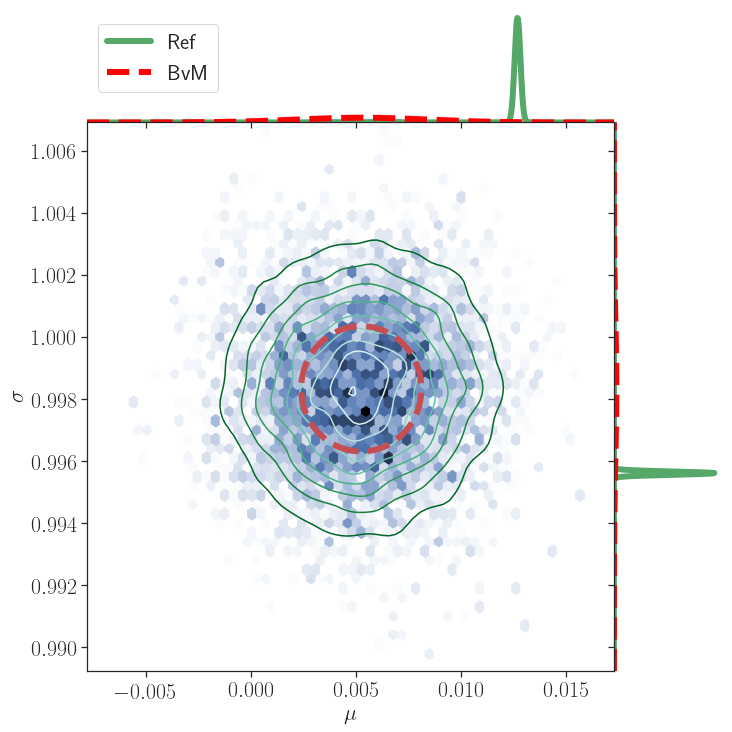

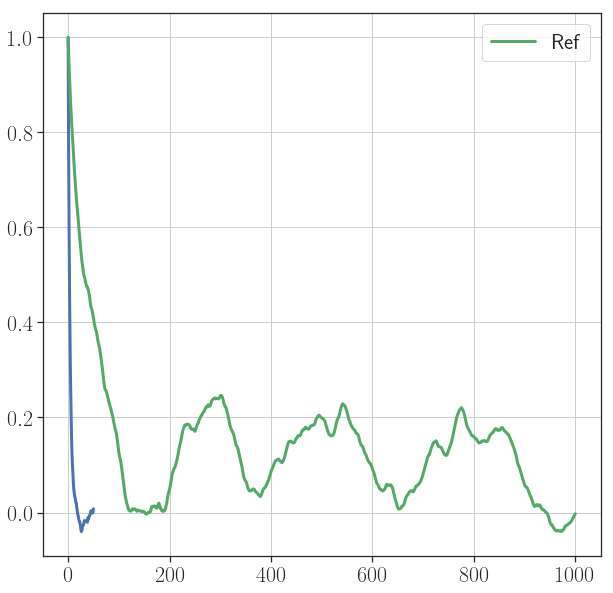

In [167]:
plotResults(S, [], algoName="vanillaMH", boolSave=1)

# ISS-MCMC

In [238]:
def sufficient_stat(samples):
    '''
    Compute a sufficient stat for our problem.
    '''
    # clearly wrong cause we dont know std but w/e
    return np.array([np.sum(samples), np.sum(samples*samples)])

In [239]:
sufficient_stat(np.array(range(5)))

array([10, 30])

In [228]:
def l2_norm_squared(vec: np.array):
    import math
    return np.sum(vec * vec)

In [207]:
def symmetric_sample_proposal(sample_indices,n,k):
    import random as ran
    out_sample = set(range(n)) - set(sample_indices)
    in_samples_leaving = ran.sample(sample_indices,k)
    out_samples_joining = ran.sample(out_sample, k)
    in_sample = set(sample_indices) - set(in_samples_leaving) | set(out_samples_joining)
    return list(in_sample)
    

In [208]:
# Sanity check for proposal function
fake_x = np.array(range(5)) * 5
print(fake_x)
sub_sample_n = 3
import random as ran
sample_indices = ran.sample(range(len(fake_x)),sub_sample_n)
print(sample_indices)
a = symmetric_sample_proposal(sample_indices,5,2)
print(a)

[ 0  5 10 15 20]
[2, 4, 0]
[1, 2, 3]


In [244]:
def ISS_MCMC(T,n,k):
    """
    perform traditional isotropic random walk Metropolis
    """
    # Discarding first value in each chain
    # Initialisation
    theta = np.array([realMean,np.log(realStd)])
    statistic_on_full_sample = sufficient_stat(x)
    # Need indices specifically for exploring the sub_samples
    import random as ran
    sub_sample_indices = ran.sample(range(len(x)),n)

    # Tuning parameters
    eps = 20 # 0 -> inf

    stepsize = .5/np.sqrt(N)
    theta_chain = np.zeros((T, 2))
    # We dont need to keep the sample chain - might be nice to keep a statistics one?
    # Suff stat here is 2D
    sample_stat_chain = np.zeros((T, 2))
    theta_acceptance = 0.0
    sample_acceptance = 0.0
    accepted_theta = 0
    accepted_samples = 0
    scalar = len(x)/n
    
    for i in range(T):
        sub_sample = x[sub_sample_indices]
        stat_on_subsample = scalar*sufficient_stat(sub_sample)

        prop_sample_indices = symmetric_sample_proposal(sub_sample_indices,n,k)
        prop_subsample = x[prop_sample_indices]
        prop_stat_on_subsample = scalar*sufficient_stat(prop_subsample)

        current_sample_delta = statistic_on_full_sample - stat_on_subsample
        proposal_sample_delta = statistic_on_full_sample - prop_stat_on_subsample
        
        import math
        log_odds = eps*(l2_norm_squared(current_sample_delta)-l2_norm_squared(proposal_sample_delta))
        log_u = np.log(npr.rand())
        if log_u<log_odds:
            sample_stat_chain[i,:] = prop_stat_on_subsample
            sub_sample_indices = prop_sample_indices
            sub_sample = prop_subsample
            accepted_samples += 1
        else:
            sample_stat_chain[i,:] = stat_on_subsample
        
        sample_acceptance = accepted_samples/(i+1)


        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhd(sub_sample, thetaP[0], np.exp(thetaP[1])) - getLogLhd(sub_sample, theta[0], np.exp(theta[1]))
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted_theta +=1
            accepted = 1
            theta_chain[i,:] = thetaNew
        else:
            theta_chain[i,:] = theta
            
        # if i<T/10:
        #     # Perform some adaptation of the stepsize in the early iterations
        #     stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        theta_acceptance = accepted_theta/(i+1)
        if np.mod(i,T/10)==0:
            print("Iteration", i, "Theta Acceptance", theta_acceptance, "Sample Acceptance", sample_acceptance)
            
    return (theta_chain, sample_stat_chain)

In [241]:
budget = 10000
ISS_S, stats = ISS_MCMC(budget,int(math.pow(budget,0.5)),10)

Iteration 0 Theta Acceptance 0.0 Sample Acceptance 0.0
Iteration 1000 Theta Acceptance 0.6843156843156843 Sample Acceptance 0.008991008991008992
Iteration 2000 Theta Acceptance 0.6881559220389805 Sample Acceptance 0.004997501249375313
Iteration 3000 Theta Acceptance 0.7027657447517495 Sample Acceptance 0.0036654448517160947
Iteration 4000 Theta Acceptance 0.7083229192701824 Sample Acceptance 0.002749312671832042
Iteration 5000 Theta Acceptance 0.7088582283543291 Sample Acceptance 0.0021995600879824036
Iteration 6000 Theta Acceptance 0.7058823529411765 Sample Acceptance 0.0018330278286952174
Iteration 7000 Theta Acceptance 0.7074703613769462 Sample Acceptance 0.001571204113698043
Iteration 8000 Theta Acceptance 0.7074115735533059 Sample Acceptance 0.0016247969003874516
Iteration 9000 Theta Acceptance 0.7056993667370293 Sample Acceptance 0.0015553827352516388


In [ ]:
plot_trace(stats)

xlims = -0.00940368489361833 0.016913571197349073
chain_Gaussian_iss_mcmc_basic.pdf


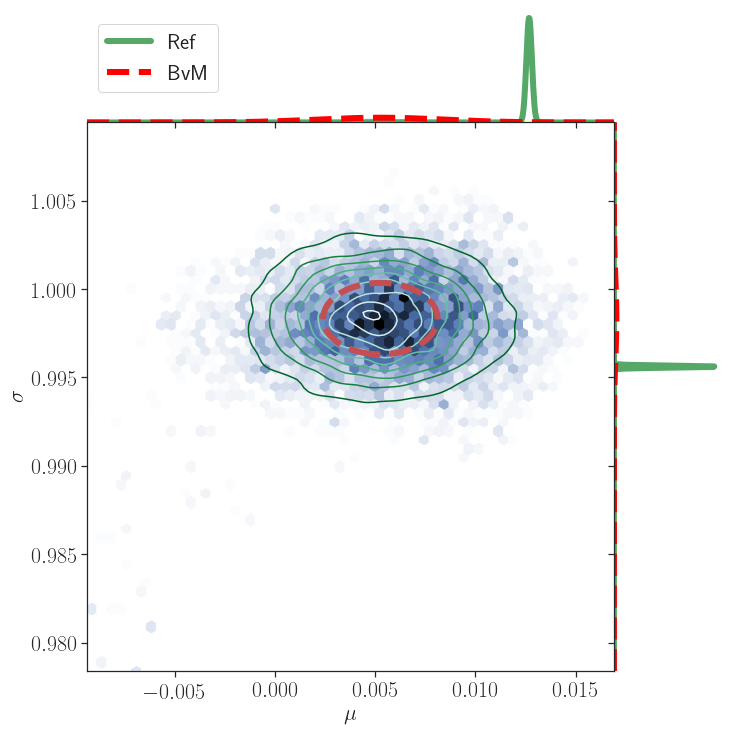

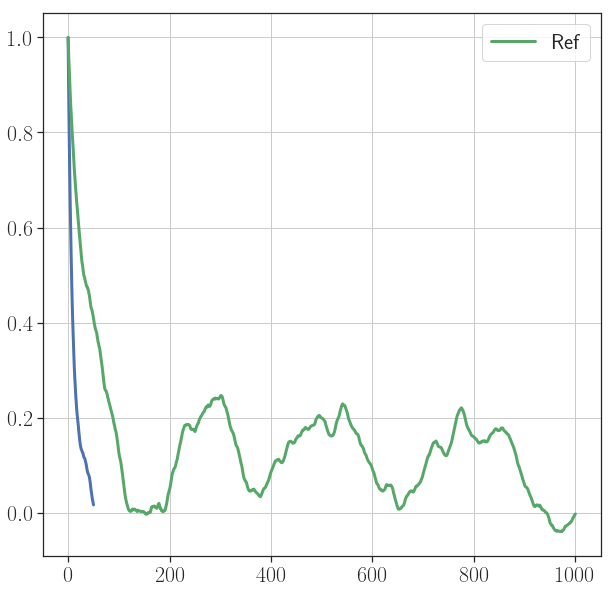

Median= nan
Plots saved


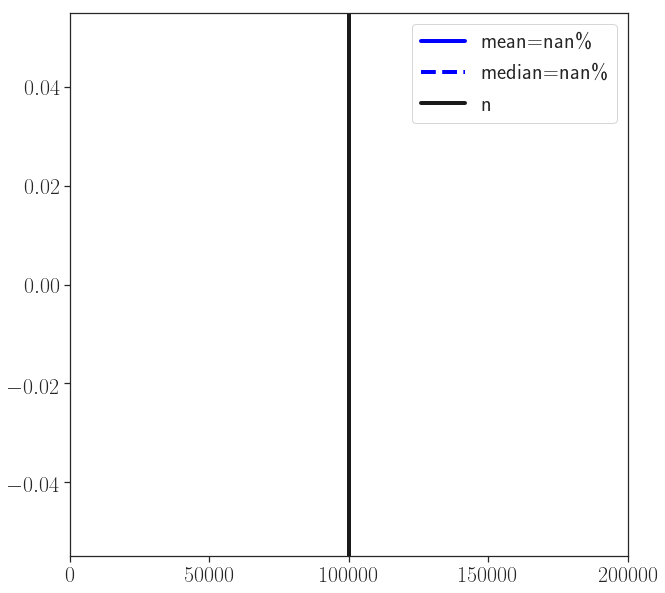

In [242]:
plotResults(ISS_S, [], algoName="iss_mcmc", boolSave=1)

## Vanilla confidence sampler

In [121]:
# Confidence MCMC (Bardenet, Doucet, and Holmes, ICML'14)

def confidenceMCMC(T):
    
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 1.5
    ns_B = []
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = N/10
        cpt = 0
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        a = np.min(lhds)
        b = np.max(lhds)
            
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            cpt+=1
            deltaP = delta/2/cpt**2
            # The following step should be done differently to avoid recomputing previous likelihoods, but for the toy examples we keep it short
            lhds = getLogLhd(x[:n], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:n], theta[0], np.exp(theta[1])) 
            Lambda = np.mean(lhds)
            sigma = np.std(lhds)
            psi = np.log(u)/N
            if np.abs(Lambda-psi) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n) # The algorithm required all likelihoods for theta and theta', next iteration we can reuse half of them
        
        if Lambda>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
            
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num evals", np.mean(ns_B), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", (b-a)/n)
        
    return S_B, ns_B

In [122]:
S_B, ns_B = confidenceMCMC(10000)

Iteration 0 Acceptance 0.0 Avg. num evals 200000.0 sigma/sqrt(n) 6.868753621471194e-05 R/n 2.2063395709758304e-06
Iteration 1000 Acceptance 0.49650349650349646 Avg. num evals 148696.61138861137 sigma/sqrt(n) 1.2443053101300207e-05 R/n 3.4708199874298184e-07
Iteration 2000 Acceptance 0.5002498750624688 Avg. num evals 148716.1059470265 sigma/sqrt(n) 7.224204805359375e-06 R/n 2.4797961840868135e-07
Iteration 3000 Acceptance 0.5048317227590793 Avg. num evals 148592.33988670443 sigma/sqrt(n) 1.8635925319638044e-05 R/n 6.561505174167148e-07
Iteration 4000 Acceptance 0.5078730317420637 Avg. num evals 148570.58610347414 sigma/sqrt(n) 5.816033981098541e-06 R/n 1.5230916847007948e-07
Iteration 5000 Acceptance 0.5056988602279532 Avg. num evals 148646.89042191562 sigma/sqrt(n) 2.0746617003272243e-06 R/n 8.459912064532893e-08
Iteration 6000 Acceptance 0.5042492917847019 Avg. num evals 148675.37177137143 sigma/sqrt(n) 1.026788744735832e-05 R/n 3.6003118066368025e-07
Iteration 7000 Acceptance 0.50521

xlims = -0.0037002230715684125 0.017777855841269667
chain_Gaussian_vanillaConfidence_basic.pdf


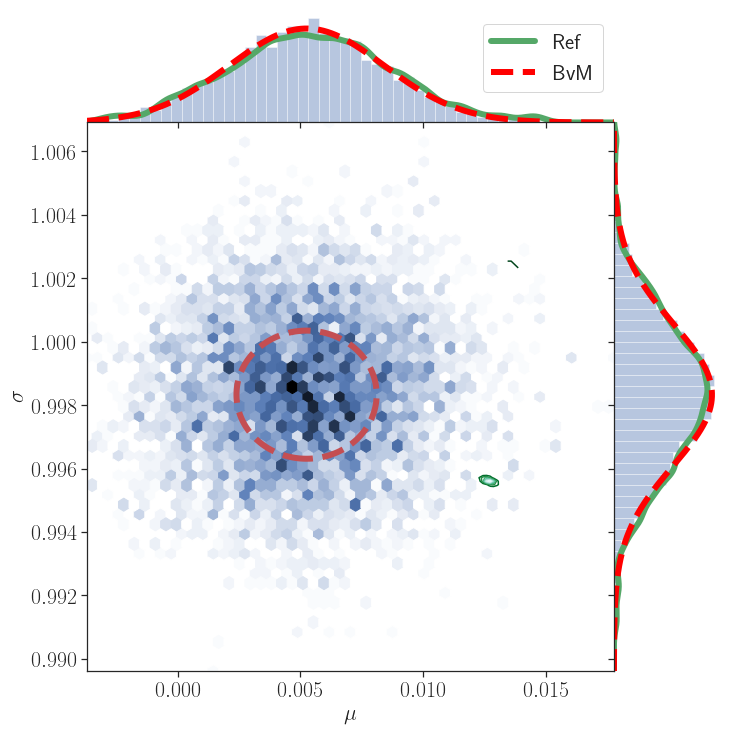

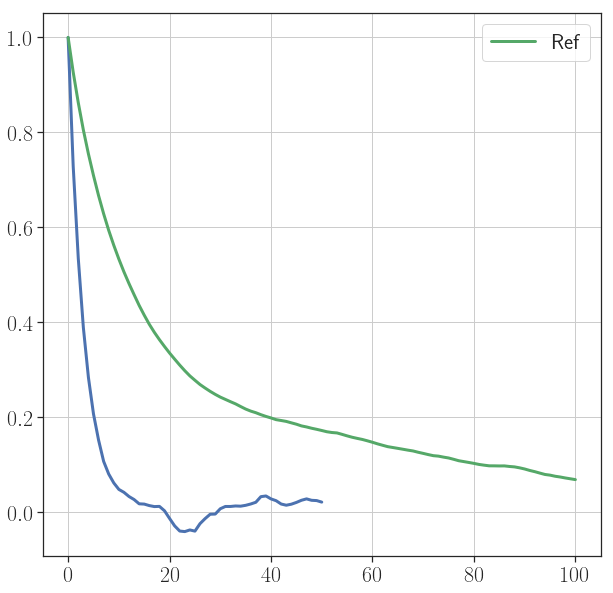

Median= 100000.0
Plots saved


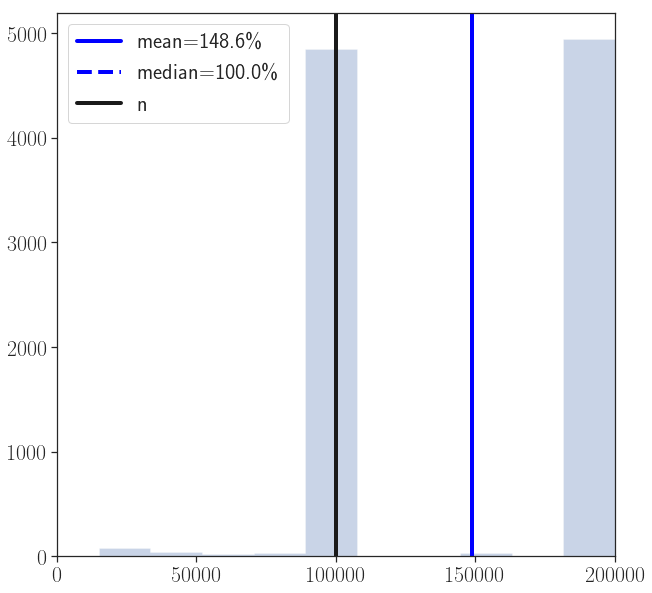

In [124]:
plotResults(S_B, ns_B, boolSave=1, algoName="vanillaConfidence")

## Confidence MH with 2nd order Taylor likelihood proxy

In [125]:
def combineMeansAndSSQs(N1, mu1, ssq1, N2, mu2, ssq2):
    """
    combine means and sum of squares of two sets
    """
    dd = mu2 - mu1
    mu = mu1
    ssq = ssq1
    N = N1+N2
    mu += dd*N2/N
    ssq += ssq2
    ssq += (dd**2) * N1 * N2 / N
    return N, mu, ssq

In [126]:
# Concentration bounds
def ctBernsteinSerfling(N,n,a,b,sigma,delta):
    """
    Bernstein-type bound without replacement, from (Bardenet and Maillard, to appear in Bernoulli)
    """
    l5 = np.log(5/delta)
    kappa = 7.0/3+3/np.sqrt(2)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return sigma*np.sqrt(2*rho*l5/n) + kappa*(b-a)*l5/n

def ctHoeffdingSerfling(N,n,a,b,delta):
    """
    Classical Hoeffding-type bound without replacement, from (Serfling, Annals of Stats 1974)
    """
    l2 = np.log(2/delta)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return (b-a)*np.sqrt(rho*l2/2/n)

def ctBernstein(N,n,a,b,sigma,delta):
    """
    Classical Bernstein bound, see e.g. the book by Boucheron, Lugosi, and Massart, 2014.
    """
    l3 = np.log(3/delta)
    return sigma*np.sqrt(2*l3/n) + 3*(b-a)*l3/n

In [127]:
# Differential functions for proxies, 

# Define vectorized evaluation of gradient and Hessian
myGradientVect = lambda x_float, mu_float, sigma_float:np.array([-(2*mu_float - 2*x_float)/(2*sigma_float**2), -1/sigma_float + (-mu_float + x_float)**2/sigma_float**3]).T
myHessianVect = lambda x_float, mu_float, sigma_float:[[-1/sigma_float**2*np.ones(x_float.shape), 2*(mu_float - x_float)/sigma_float**3], [2*(mu_float - x_float)/sigma_float**3, (1 - 3*(mu_float - x_float)**2/sigma_float**2)/sigma_float**2]]

# Compute third order derivatives to bound the Taylor remainder. Symbolic differentiation is not really necessary in this simple case, but
# it may be useful in later applications
def thirdDerivatives():
    x, mu, sigma = sym.symbols('x, mu, sigma')
    L = []
    for i in range(4):
        for j in range(4):
            if i+j == 3:
                args = tuple([-(x-mu)**2/(2*sigma**2) -sym.log(sigma)] + [mu for cpt in range(i)] + [sigma for cpt in range(j)])                
                L.append( sym.diff(*args) )
    return L
    
def evalThirdDerivatives(x_float, mu_float, logSigma_float): 
    tt = thirdDerivatives()
    return [tt[i].subs('x',x_float).subs('mu',mu_float).subs('sigma',np.exp(logSigma_float)).evalf() for i in range(4)]

# Find the MAP (not really necessary here since the MAP are the mean and std deviation of the data)
f = lambda theta: -np.mean(getLogLhd(x, theta[0], np.exp(theta[1])))
thetaMAP = spo.minimize(f, np.array([realMean, np.log(realStd)])).x
print("MAP is", thetaMAP, "Real values are", realMean, np.log(realStd))
tt = thirdDerivatives()
print(tt)

MAP is [ 0.00525303 -0.00167212] Real values are 0.005253028489682668 -0.0016721236781780497
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]


We will need to bound the absolute value of the third derivatives.

In [128]:
tt = thirdDerivatives()
print(tt)

[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]


To apply the two Taylor expansions, it is enough to bound them on the union of the two segments 
$$\{(1-t)\theta^\star+t\theta, t\in[0,1]\}\cup\{(1-t)\theta^\star+t\theta', t\in[0,1]\},$$
where $\theta=(\mu,\sigma)$. Given their form, it is enough to bound them by taking the max of their absolute values when $\vert x-\mu\vert$ is maximal and $\sigma$ minimal in this union. Since the code is a bit hard to read, we have added a simple check of the bound in the algorithm to convince the reader the bound is correct.

In [134]:
# Confidence MCMC with proxy (Bardenet, Doucet, and Holmes, this submission)
def confidenceMCMCWithProxy(T):
    
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute some statistics of the data that will be useful for bounding the error and averaging the proxies    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare total sum of Taylor proxys
    muMAP = thetaMAP[0]
    sigmaMAP = np.exp(thetaMAP[1])
    meanGradMAP = np.array( [(meanx - muMAP)/sigmaMAP**2, (meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**3 - 1./sigmaMAP] )
    meanHessMAP = np.array( [[-1./sigmaMAP**2, -2*(meanx-muMAP)/sigmaMAP**3], [-2*(meanx-muMAP)/sigmaMAP**3, -3*(meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**4 + 1/sigmaMAP**2]] )    
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0 # Sum of squares
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaMAP[0], maxx-thetaMAP[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaMAP[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaMAP[0], np.exp(theta[1])-np.exp(thetaMAP[1])])
        hP = np.array([thetaP[0]-thetaMAP[0], np.exp(thetaP[1])-np.exp(thetaMAP[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        # We can already compute the average proxy log likelihood ratio
        avgTotalProxy = np.dot(meanGradMAP, hP-h) + .5*np.dot( hP-h, np.dot(meanHessMAP, h+hP) ) 
        
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muMAP, sigmaMAP), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muMAP,sigmaMAP)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                # Just a check that our error is correctly bounded
                print("Taylor remainder is underestimated")
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n)
        
    return S_B, ns_B

In [135]:
S_BP, ns_BP = confidenceMCMCWithProxy(10000)

Iteration 0 Acceptance 0.0 Avg. num samples 1024.0 Dist. to MAP 0.0 sigma/sqrt(n) 3.1400407998697378e-09 R/n 6.472474098772881e-08
Iteration 1000 Acceptance 0.49850149850149844 Avg. num samples 859.6443556443556 Dist. to MAP 0.0002493180558642183 sigma/sqrt(n) 1.4922771358953814e-10 R/n 5.055738236017867e-08
Iteration 2000 Acceptance 0.5072463768115952 Avg. num samples 954.4067966016992 Dist. to MAP 0.006159889279033106 sigma/sqrt(n) 4.936900849756234e-09 R/n 3.465209167566397e-08
Iteration 3000 Acceptance 0.501166277907365 Avg. num samples 941.0996334555148 Dist. to MAP 0.01094998680527021 sigma/sqrt(n) 4.079562404466572e-08 R/n 1.8371592178874277e-07
Iteration 4000 Acceptance 0.49337665583604184 Avg. num samples 960.5278680329917 Dist. to MAP 0.0029151686946896358 sigma/sqrt(n) 1.9158167836491284e-08 R/n 1.9431378819589278e-07
Iteration 5000 Acceptance 0.49610077984403195 Avg. num samples 1092.483903219356 Dist. to MAP 0.0010866662283206192 sigma/sqrt(n) 6.267807754119507e-08 R/n 2.1

xlims = -0.005429773489634872 0.01873279687387648
chain_Gaussian_confidenceProxy_basic.pdf


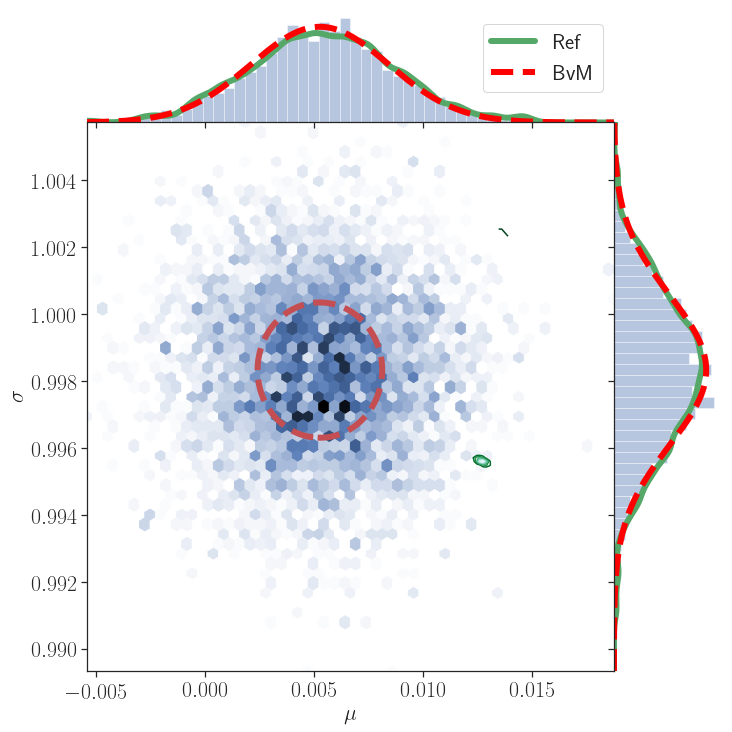

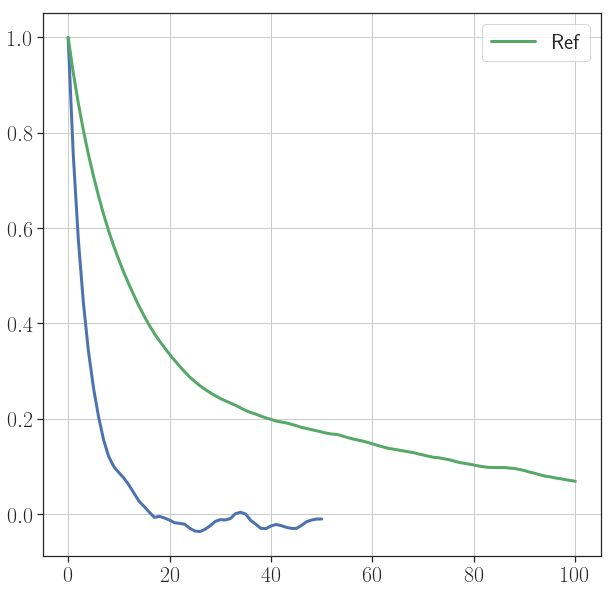

Median= 256.0
Plots saved


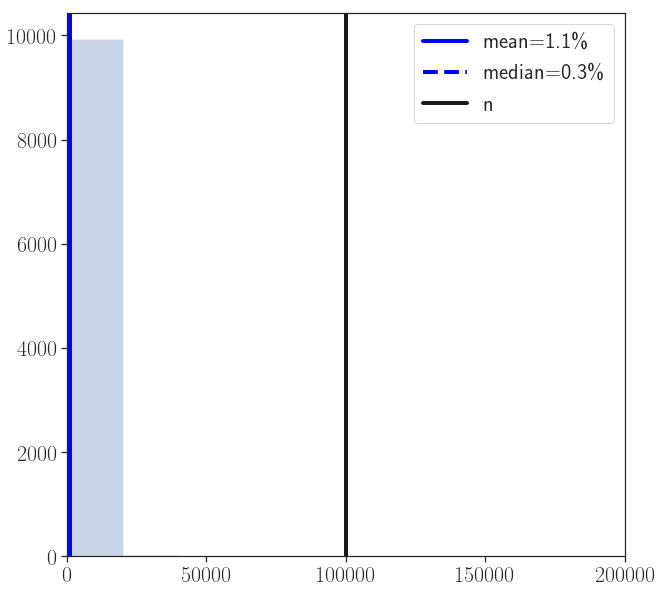

In [136]:
plotResults(S_BP, ns_BP, algoName="confidenceProxy", boolSave=1)

## Confidence MCMC with proxys dropped along the way

This is a version of the confidence sampler with proxy that drops a proxy every 20 iterations.

In [139]:
def dropProxy(thetaStar, meanx, minx, maxx, meanxSquared):
    """
    compute all quantities necessary to the evaluation of a proxy at thetaStar
    """
    muStar = thetaStar[0]
    sigmaStar = np.exp(thetaStar[1])
    meanGradStar = np.array( [(meanx - muStar)/sigmaStar**2, (meanxSquared-2*muStar*meanx+muStar**2)/sigmaStar**3 - 1./sigmaStar] )
    meanHessStar = np.array( [[-1./sigmaStar**2, -2*(meanx-muStar)/sigmaStar**3], [-2*(meanx-muStar)/sigmaStar**3, -3*(meanxSquared-2*muStar*meanx+muStar**2)/sigmaStar**4 + 1/sigmaStar**2]] )    
    return meanGradStar, meanHessStar

def confidenceMCMCWithProxyDroppedAlong(T):
    """
    perform confidence MCMC with proxy dropped every 20 iterations
    """
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .1 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute min and max of data    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare Taylor proxys
    thetaStar = thetaMAP
    muStar = thetaStar[0]
    sigmaStar = np.exp(thetaStar[1])
    meanGradStar, meanHessStar = dropProxy(thetaStar, meanx, minx, maxx, meanxSquared)
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaStar[0], maxx-thetaStar[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaStar[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaStar[0], np.exp(theta[1])-np.exp(thetaStar[1])])
        hP = np.array([thetaP[0]-thetaStar[0], np.exp(thetaP[1])-np.exp(thetaStar[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        avgTotalProxy = np.dot(meanGradStar, hP-h) + .5*np.dot( hP-h, np.dot(meanHessStar, h+hP) ) 
        
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            
            if not np.mod(i,20): # Loop over whole dataset and recompute proxys when finished
                n = N
            
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muStar, sigmaStar), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muStar,sigmaStar)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                print("Taylor remainder is underestimated")
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            #print "n, abs(L-psi), bound, sigma/sqrt(n), R/n", n, np.abs(Lambda-psi), ctBernstein(N,n,a,b,sigma,deltaP), sigma/np.sqrt(n), R/n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if not np.mod(i,20): # Recompute proxys every 20 iterations
            thetaStar = theta
            muStar = thetaStar[0]
            sigmaStar = np.exp(thetaStar[1])
            meanGradStar, meanHessStar = dropProxy(thetaStar, meanx, minx, maxx, meanxSquared)
                
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n)
        
    return S_B, ns_B

In [140]:
S_BPD, ns_BPD = confidenceMCMCWithProxyDroppedAlong(10000)

Iteration 0 Acceptance 0.0 Avg. num samples 200000.0 Dist. to MAP 0.0 sigma/sqrt(n) 2.1927282511985025e-07 R/n 3.5971396163282044e-07
Iteration 1000 Acceptance 0.48451548451548465 Avg. num samples 12082.62137862138 Dist. to MAP 0.0009831291129169366 sigma/sqrt(n) 8.382521594647016e-11 R/n 6.412787558695552e-11
Iteration 2000 Acceptance 0.504247876061968 Avg. num samples 12248.56571714143 Dist. to MAP 0.006136722230690384 sigma/sqrt(n) 9.736603679951211e-10 R/n 5.398753411241823e-10
Iteration 3000 Acceptance 0.4991669443518822 Avg. num samples 11999.257580806398 Dist. to MAP 0.010889353561791996 sigma/sqrt(n) 4.3923139281366806e-09 R/n 4.17882457957726e-09
Iteration 4000 Acceptance 0.49412646838290364 Avg. num samples 11968.408897775556 Dist. to MAP 0.00229125241968861 sigma/sqrt(n) 3.2463240093998223e-10 R/n 1.0800762045293723e-10
Iteration 5000 Acceptance 0.49850029994001144 Avg. num samples 12009.814037192562 Dist. to MAP 0.001131538308182441 sigma/sqrt(n) 4.3031156368977954e-10 R/n 

xlims = -0.00597274254456956 0.018676415666650084
chain_Gaussian_doesNotMatter_basic.pdf


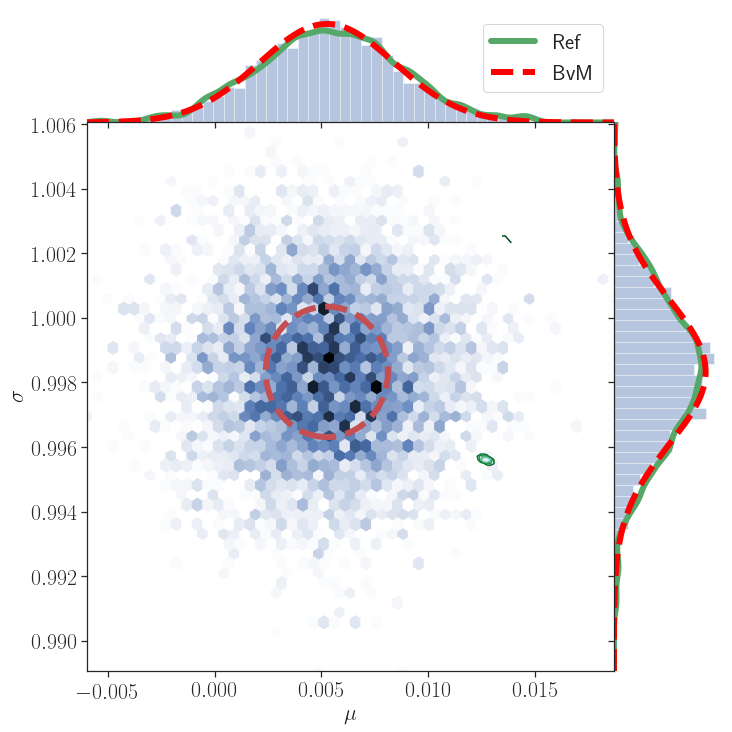

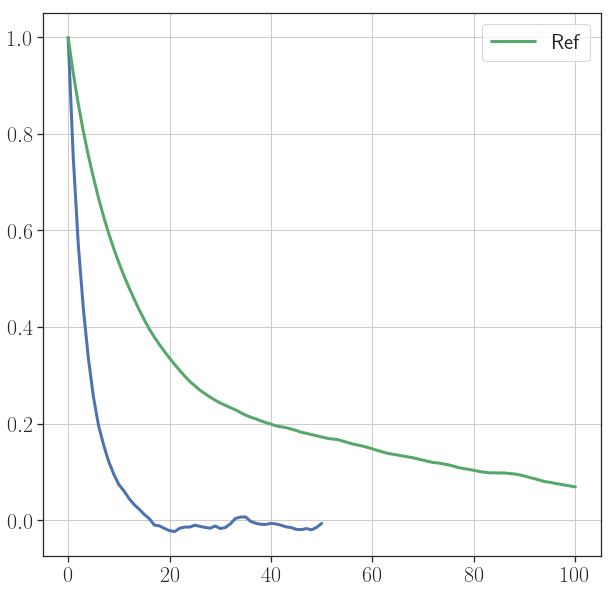

Median= 256.0


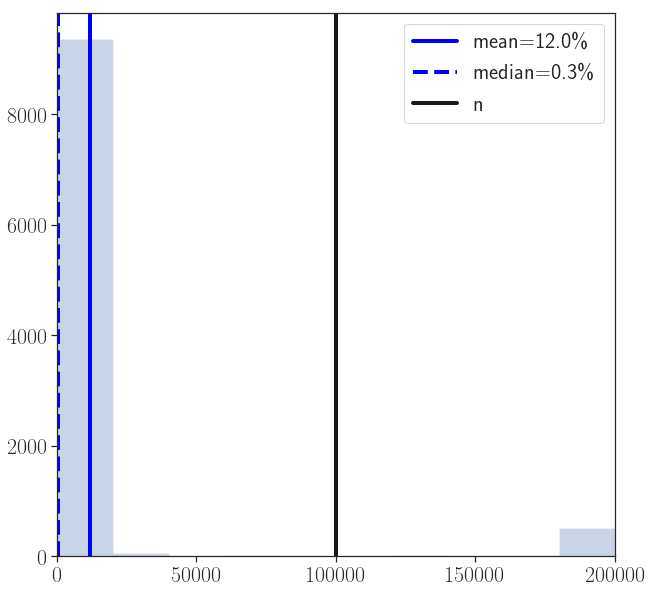

In [141]:
plotResults(S_BPD, ns_BPD)

## Firefly MH with 2nd order Taylor lower bound

In [144]:
# Firefly MH with same Taylor bound as the confidence sampler with proxy
def fireflyMHWithTaylorBound(T):
    
    # Initialize
    theta = np.array([realMean, np.log(realStd)]) 
    z = np.zeros((N,))
    z[npr.randint(0, N, int(N/10))] = 1 # Start with 10% bright points
    stepsize = 1./np.sqrt(N) 
    S = np.zeros((T,2))
    acceptance = 0.0
    ns = []
    nsBright = []
    resampleFraction = .1 # Try resampling this fraction of the z's at each iteration
    numResampledZs = int(np.ceil(N*resampleFraction))
    
    # Compute min and max of data    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    print("min and max computed")
    
    # Prepare total sum of Taylor proxys
    muMAP = thetaMAP[0]
    sigmaMAP = np.exp(thetaMAP[1])
    logLhdMAP = getLogLhd(x, muMAP, sigmaMAP)
    meanGradMAP = np.array( [(meanx - muMAP)/sigmaMAP**2, (meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**3 - 1./sigmaMAP] )
    meanHessMAP = np.array( [[-1./sigmaMAP**2, -2*(meanx-muMAP)/sigmaMAP**3], [-2*(meanx-muMAP)/sigmaMAP**3, -3*(meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**4 + 1/sigmaMAP**2]] )    
    print("Taylor preprocessing done")
    
    for i in range(T):
        
        accepted = 0
        done = 0
        
        #-----------------------------------------------------
        # Prepare proposal on theta and MH's uniform draw
        #-----------------------------------------------------
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        psi = 1./N*np.log(u)
        
        #-----------------------------------------------------
        # Prepare Taylor bounds
        #-----------------------------------------------------
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaMAP[0], maxx-thetaMAP[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaMAP[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        RP = R # We could tighten the bounds by considering theta and thetaP separately. Given the results, this is unnecessary
        
        h = np.array([theta[0]-thetaMAP[0], np.exp(theta[1])-np.exp(thetaMAP[1])])
        hP = np.array([thetaP[0]-thetaMAP[0], np.exp(thetaP[1])-np.exp(thetaMAP[1])]) 
        
        R *= 1./6 * np.sum(np.abs(h))**3 # no multiplication by 2 since only one point
        RP *= 1./6 * np.sum(np.abs(hP))**3 # no multiplication by 2 since only one point
    
        avgLogBound = np.mean(logLhdMAP) + np.dot(meanGradMAP, h) + .5*np.dot( h, np.dot(meanHessMAP, h) ) - R
        avgLogBoundP = np.mean(logLhdMAP) + np.dot(meanGradMAP, hP) + .5*np.dot( hP, np.dot(meanHessMAP, hP) ) - RP
        
        #-----------------------------------------------------
        # Resample z's
        #-----------------------------------------------------
        resampledInds = npr.randint(0, N, size=numResampledZs)
        L = np.exp(getLogLhd(x[resampledInds], theta[0], np.exp(theta[1])))
        logB = logLhdMAP[resampledInds] + np.dot(myGradientVect(x[resampledInds], muMAP, sigmaMAP), h) + 0.5*np.dot(np.dot(h, myHessianVect(x[resampledInds], muMAP, sigmaMAP)).T, h) - R
        B = np.exp(logB)
        z[resampledInds] = npr.binomial(1, 1-B/L)
        
        #-----------------------------------------------------
        # Compute posterior for acceptance of theta move
        #-----------------------------------------------------
        indsBright = z==1
        numBright = np.sum(indsBright)
        logB = logLhdMAP[indsBright] + np.dot(myGradientVect(x[indsBright], muMAP, sigmaMAP), h) + 0.5*np.dot(np.dot(h, myHessianVect(x[indsBright], muMAP, sigmaMAP)).T, h) - R
        B = np.exp(logB) 
        L = np.exp(getLogLhd(x[indsBright], theta[0], np.exp(theta[1])))
        logBP = logLhdMAP[indsBright] + np.dot(myGradientVect(x[indsBright], muMAP, sigmaMAP), hP) + 0.5*np.dot(np.dot(hP, myHessianVect(x[indsBright], muMAP, sigmaMAP)).T, hP) - RP
        BP = np.exp(logBP) 
        LP = np.exp(getLogLhd(x[indsBright], thetaP[0], np.exp(thetaP[1])))
        
        #-----------------------------------------------------
        # Accept/reject step
        #-----------------------------------------------------
        Lambda = (avgLogBoundP-avgLogBound) # sum of log of bounds
        Lambda += 1./N*( np.sum(np.log(LP/BP - 1)) - np.sum(np.log(L/B - 1)) ) # if the lower bound is wrong, this will raise a flag
        if Lambda > psi:
            # Accept
            theta = thetaP
            accepted = 1
            S[i] = thetaP
        else:
            # Reject
            S[i] = theta
        
        #-----------------------------------------------------
        # Save number of evaluations of the likelihood during this iteration
        #-----------------------------------------------------
        ns.append(numBright + numResampledZs) # This is an upper estimate of the number of cost units
        nsBright.append(numBright)
        
        #-----------------------------------------------------
        # Update stepsize, acceptance and print status
        #-----------------------------------------------------
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        #print "t4=", time.time() - tic
        
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", int(100*acceptance), "% Avg. num lhds", np.mean(ns), "Avg num bright samples", np.mean(nsBright), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ))
        
    return S, ns, nsBright

In [145]:
S_F, ns_F, nsBright_F = fireflyMHWithTaylorBound(10000)

min and max computed
Taylor preprocessing done
Iteration 0 Acceptance 100 % Avg. num lhds 18612.0 Avg num bright samples 8612.0 Dist. to MAP 0.00837397300713092
Iteration 1000 Acceptance 51 % Avg. num lhds 10170.19080919081 Avg num bright samples 170.1908091908092 Dist. to MAP 0.0027663934580374255
Iteration 2000 Acceptance 50 % Avg. num lhds 10085.95952023988 Avg num bright samples 85.95952023988006 Dist. to MAP 0.004973464636901211
Iteration 3000 Acceptance 49 % Avg. num lhds 10057.470176607798 Avg num bright samples 57.4701766077974 Dist. to MAP 0.008282305693159256
Iteration 4000 Acceptance 49 % Avg. num lhds 10043.33841539615 Avg num bright samples 43.338415396150964 Dist. to MAP 0.000989426582142233
Iteration 5000 Acceptance 49 % Avg. num lhds 10034.798240351929 Avg num bright samples 34.798240351929614 Dist. to MAP 0.00243634531646934
Iteration 6000 Acceptance 49 % Avg. num lhds 10029.079986668889 Avg num bright samples 29.07998666888852 Dist. to MAP 0.001737346138171018
Iterati

xlims = -0.006079052446370091 0.01582784433711271
chain_Gaussian_fireflyMH_resampling10p.pdf


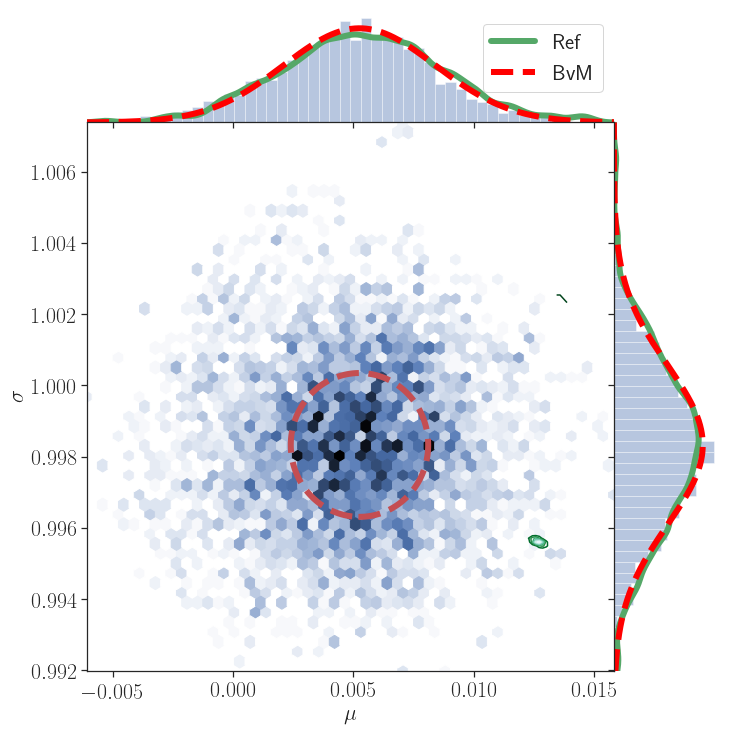

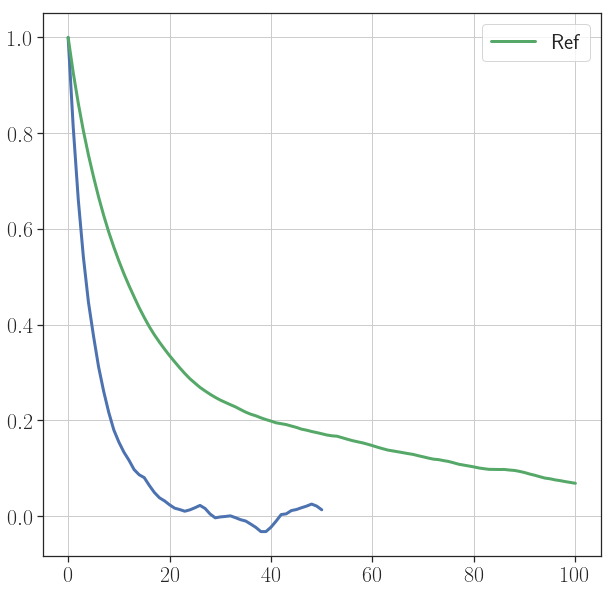

Median= 10000.0


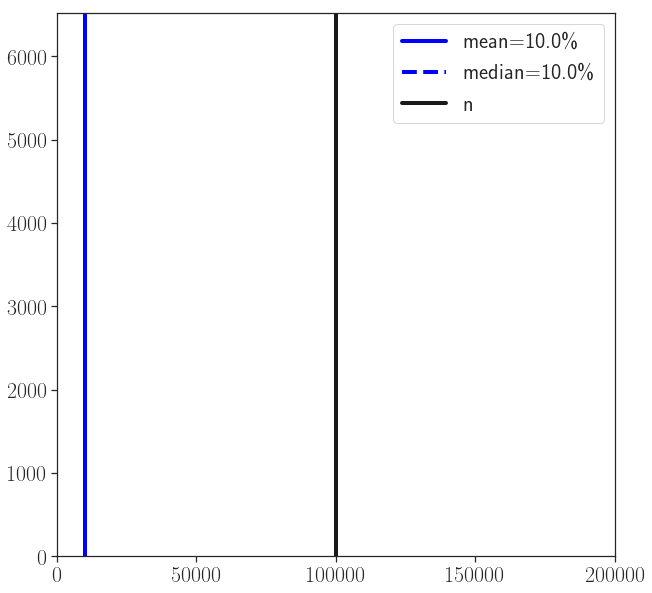

In [146]:
plotResults(S_F[1000:,], ns_F[1000:], algoName="fireflyMH", boolSave=0, figId="resampling10p")
plt.show()
plt.plot(nsBright_F)